# Plotting Emissions data from HERWIG Simulation
Rosie Schiffmann <br>
University of Manchester <br>
July 2025

# 1. Introduction
In this notebook, energy and power consumption data obtained from running particle physics event generation simulations using HERWIG is plotted. CPU and RAM energy and power consumption, alongside estimated CO2e emissions was tracked by CodeCarbon. The simulation complexity was varied across runs by changing the total number of events generated by HERWIG, and tracking was performed separately for the integration and generation phases of simulation. During the integration phase, the total cross section is calculated by numerically integrating the squared matrix elements over the allowed phase space of the process. In the generation phase, Herwig samples specific final states based on the probability distribution obtained in the integration phase, and then simulates parton showers, hadronisation, and hadron decays using Monte Carlo techniques.

Data for individual runs from CodeCarbon is stored in CSV files, that follow the naming convention YYYYMMDDType_metadata_EVENTS_JOBS.csv. YYYYMMDD represents the date that the simulations were run. Type is either Int or Gen, to represent data recorded duting the integration or generation phase respectively. EVENTS is the total number of simulated events. This variable can be changed inside the run_herwig_with_cc_loop.ipynb file. JOBS represnets the number of parallel jobs for HERWIG to use, in order to speed up computation by utilising multiple cores. Data that covers the emissions produced by the entire 10 runs as a whole can be found in CSV files YYYYMMDDType_emissions_EVENTS-JOBS.csv.

Plotting functions in this notebook are taken from the emission_tracking.ipynb notebook in https://github.com/rosieschiffmann/event-Transport-Simulation-Energy-Estimation github repository. 

In [20]:
#import python libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import re

# 2. Data Processing

Here, we will assimilate all of the individual CSV files into 2 separate master CSV files: "Int_master_emissions_data.csv" and "Gen_master_emissions_data.csv". To do this, mean values were calculated for emissions, duration and CPU/GPU energy and power consumption for each raw data file corresponding to a different number of events.

In [21]:
#identify relevant csv files inside repository
# int_files = glob.glob("20250730Int_metadata-*-4.csv")
# gen_files = glob.glob("20250730Gen_metadata-*-4.csv")

int_files = glob.glob("*Int_metadata-*-4.csv")
gen_files = glob.glob("*Gen_metadata-*-4.csv")

def generate_master_csv(files, type):
	"""
	Function to generate a master csv file containing all data for plotting, for either the integration or generation
	phase of HERWIG.

	Parameters:
	- files (list of str): list of filenames to include in master csv
	- type (str): "Int" or "Gen" for integration phase data or generation phase data respectively
	"""
	summary_data = []

	for file in files:
		#identify and find mean of relevant data from CodeCarbon raw outputs
		df = pd.read_csv(file)
		mean_emissions = df['emissions'].mean()
		mean_duration = df['duration'].mean()
		mean_cpu_power = df['cpu_power'].mean()
		mean_ram_power = df['ram_power'].mean()
		mean_cpu_energy = df['cpu_energy'].mean()
		mean_ram_energy = df['ram_energy'].mean()
		#obtain number of events from filename
		match = re.search(r'_metadata-(\d+)-4\.csv', file)
		events = int(match.group(1)) if match else None

		#propagate errors
		emissions_err = df['emissions'].std() / np.sqrt(len(df['emissions']))
		duration_err = df['duration'].std() / np.sqrt(len(df['duration']))
		cpu_power_err = df['cpu_power'].std() / np.sqrt(len(df['cpu_power']))
		ram_power_err = df['ram_power'].std() / np.sqrt(len(df['ram_power']))
		cpu_energy_err = df['cpu_energy'].std() / np.sqrt(len(df['cpu_energy']))
		ram_energy_err = df['ram_energy'].std() / np.sqrt(len(df['ram_energy']))
		
		#add dictionary of data to summary_data list 
		summary_data.append({
			'filename': file,
			'number_of_events': events,
			'mean_emissions': mean_emissions,
			'emissions_err' : emissions_err,
			'mean_duration': mean_duration,
			'duration_err' : duration_err,
			'mean_cpu_power': mean_cpu_power,
			'cpu_power_err' : cpu_power_err,
			'mean_ram_power' : mean_ram_power,
			'ram_power_err' : ram_power_err,
			'mean_cpu_energy' : mean_cpu_energy,
			'cpu_energy_err' : cpu_energy_err,
			'mean_ram_energy' : mean_ram_energy,
			'ram_energy_err' : ram_energy_err,
			'cpu_energy_per_event' : mean_cpu_energy / events,
			'cpu_energy_per_event_err' : cpu_energy_err / events,
			'ram_energy_per_event' : mean_ram_energy / events,
			'ram_energy_per_event_err' : ram_energy_err / events,
			'duration_per_event' : mean_duration / events,
			'duration_per_event_err': duration_err / events
		})

	#convert into dataframe and create master csv file.
	summary_df = pd.DataFrame(summary_data)
	summary_df = summary_df.sort_values(by='number_of_events') #sort wrt number_of_events
	summary_df.to_csv(f"{type}_master_emissions_data.csv", index=False)
	return summary_df

int_summary_df = generate_master_csv(int_files, "Int")
gen_summary_df = generate_master_csv(gen_files, "Gen")


# 3. Plotting

In [22]:
def reduced_chi_squared(x, y, y_err, coeffs):
    """
    Calculate the reduced chi-squared for a polynomial fit.

    Parameters:
    - x: 1d array, x-values
    - y: 1d array, observed y-values
    - y_err: 1d array, uncertainties in y
    - coeffs: 1d array, polynomial coefficients from np.polyfit()

    Returns:
    - chi_squared_reduced: float
    """
    model = np.poly1d(coeffs)
    residuals = (y - model(x)) / y_err
    chi_squared = np.sum(residuals**2)
    dof = len(x) - len(coeffs)  # degrees of freedom = N - (fit order + 1)
    return chi_squared / dof

def CPU_and_RAM_plotting(df, x_variable, CPU_y_variable, CPU_y_err, RAM_y_variable, RAM_y_err, fit=False, fit_order=None):
    """
    Creates 2 plots (one for CPU and one for RAM), with axis defined by argumants. An optional polyfit is applied and reduced chi squared
    calculated.

    Parameters: 
    - df: pandas.DataFrame, containing the data to be plotted.
    - x_variable: string, name of x-axis variable for plotting from dataframe
    - CPU_y_variable: string, name of y-axis variable for CPU plot from dataframe
    - CPU_y_err: string, name of error associated with CPU y-axis variable from dataframe
    - RAM_y_variable: string, name of y-axis variable for RAM plot from dataframe
    - RAM_y_err: string, name of error associated with RAM y-axis variable from dataframe
    - fit: bool, whether or not plot should have fitting
    - fit_order: int, order of fit if fit=True
    """
    plt.rcParams["figure.figsize"] = (14,6)
    fig, ax =  plt.subplots(1,2)

    #define units of selected variables, with default as no units
    units = ['J', 'gCO2e', 's', 'W', '']
    if x_variable=='mean_duration': x_unit=2
    elif x_variable=='number_of_neutrons': x_unit=4
    else: x_unit=4

    if CPU_y_variable=="mean_cpu_energy": y_unit=0
    elif CPU_y_variable=="cpu_energy_per_neutron": y_unit=0
    elif CPU_y_variable=="mean_cpu_power":y_unit=3
    elif CPU_y_variable=="mean_emissions": y_unit=1
    else: y_unit=4
    
    if fit:
        #raise error if fit=True but no fit_order is provided
        if fit_order==None:
            raise ValueError("Order of fit must be provided if fit=True.")
        #CPU data fitting
        if np.any(df[CPU_y_err])==0.0: #do not use error-weighted fitting is errors=0
            coeffs_cpu = np.polyfit(df[x_variable], df[CPU_y_variable], deg=fit_order)
        else:
            coeffs_cpu = np.polyfit(df[x_variable], df[CPU_y_variable], deg=fit_order, w=1/df[CPU_y_err])
        poly_cpu = np.poly1d(coeffs_cpu)
        x_fit = np.linspace(df[x_variable].min(), df[x_variable].max(), 100)
        CPU_chi = reduced_chi_squared(df[x_variable], df[CPU_y_variable], df[CPU_y_err], coeffs_cpu)
        ax[0].plot(x_fit, poly_cpu(x_fit), 'r--', label=f"Fit (order {fit_order}). Reduced-chi-squared = {CPU_chi:.2g}", linewidth = 0.5)
        

        #RAM data fitting
        if np.any(df[RAM_y_err])==0.0: #do not use error-weighted fitting is errors=0
            coeffs_ram = np.polyfit(df[x_variable], df[RAM_y_variable], deg=fit_order)
        else:
            coeffs_ram = np.polyfit(df[x_variable], df[RAM_y_variable], deg=fit_order, w=1/df[RAM_y_err])
        poly_ram = np.poly1d(coeffs_ram)
        RAM_chi = reduced_chi_squared(df[x_variable], df[RAM_y_variable], df[RAM_y_err], coeffs_ram)
        ax[1].plot(x_fit, poly_ram(x_fit), 'r--', label=f"Fit (order {fit_order}). Reduced-chi-squared = {RAM_chi:.2g}", linewidth = 0.5)

    #plotting CPU data
    ax[0].errorbar(df[x_variable], df[CPU_y_variable], yerr = df[CPU_y_err], fmt = "none", capsize = 2, label = "CPU data (Intel Core i5-1235U CPU. 42.5W power-draw)")
    ax[0].set_title(f'{CPU_y_variable} vs {x_variable}')
    ax[0].set_xlabel(f'{x_variable}, {units[x_unit]}')
    ax[0].set_ylabel(f'{CPU_y_variable}, {units[y_unit]}')

    #plotting RAM data
    ax[1].errorbar(df[x_variable], df[RAM_y_variable], yerr = df[RAM_y_err], fmt = "none", capsize = 2, label = "RAM data (7.711 GB available. 10W power draw)")
    ax[1].set_title(f'{RAM_y_variable} vs {x_variable}')
    ax[1].set_xlabel(f'{x_variable}, {units[x_unit]}')
    ax[1].set_ylabel(f'{RAM_y_variable}, {units[y_unit]}')

    #plot details
    for i in range(2):
        ax[i].grid()
        ax[i].legend()
    return None

# 3.1 CPU and RAM Energy

Now, we will plot the CPU and RAM energy consumption side by side, for both the integration and the generation phases of the simulation. We will plot this with respect to simulation duration, and number of events (simulation complexity).

# 3.1.1 Integration Phase


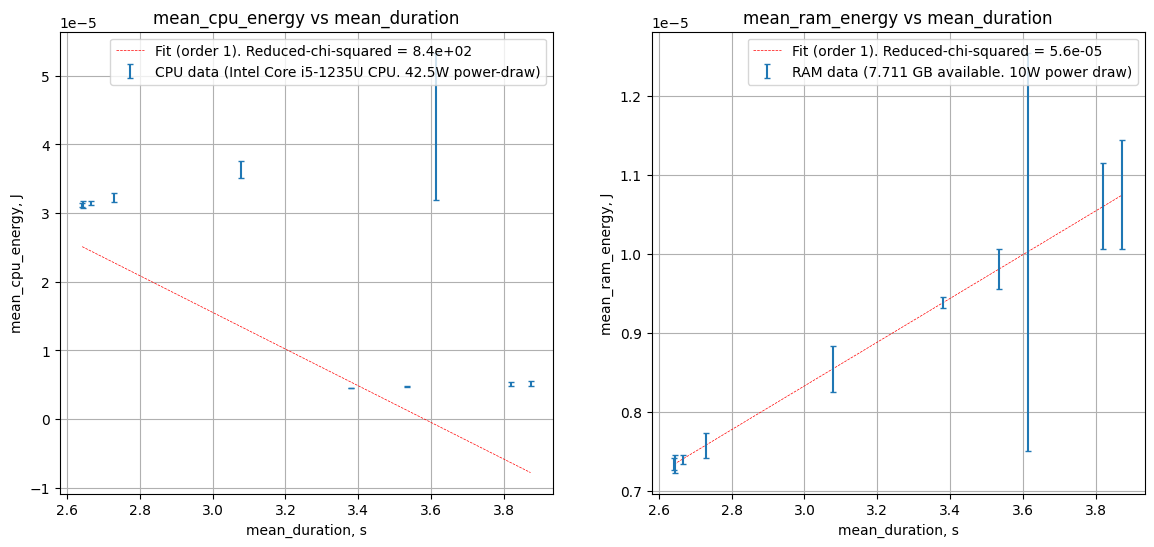

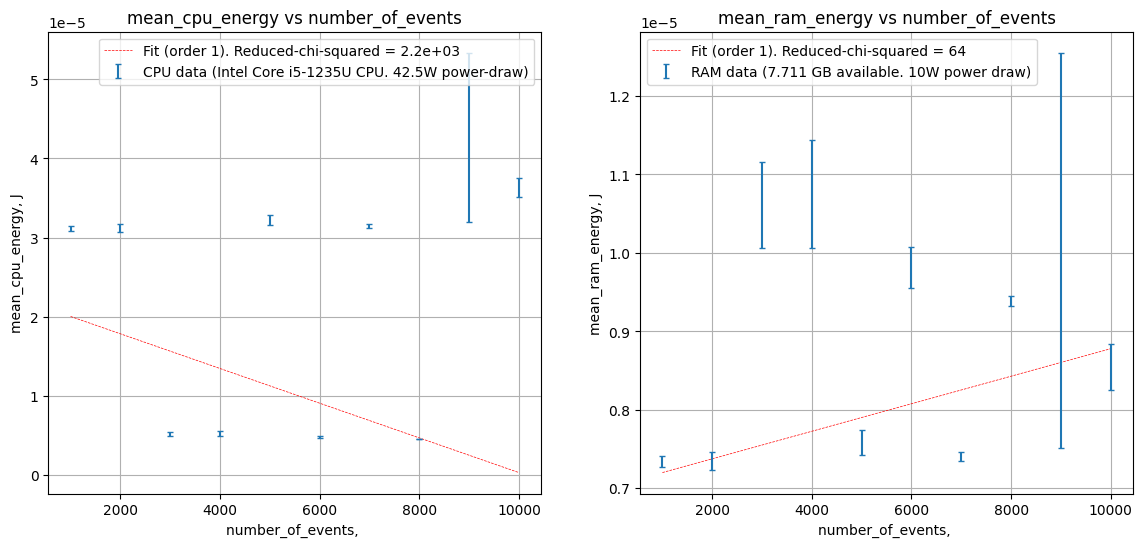

In [26]:
CPU_and_RAM_plotting(int_summary_df, "mean_duration", 
         "mean_cpu_energy", "cpu_energy_err", 
         "mean_ram_energy", "ram_energy_err", 
         True, 1)
CPU_and_RAM_plotting(int_summary_df, "number_of_events", 
         "mean_cpu_energy", "cpu_energy_err", 
         "mean_ram_energy", "ram_energy_err", 
         True, 1)

# 3.1.2 Generation Phase

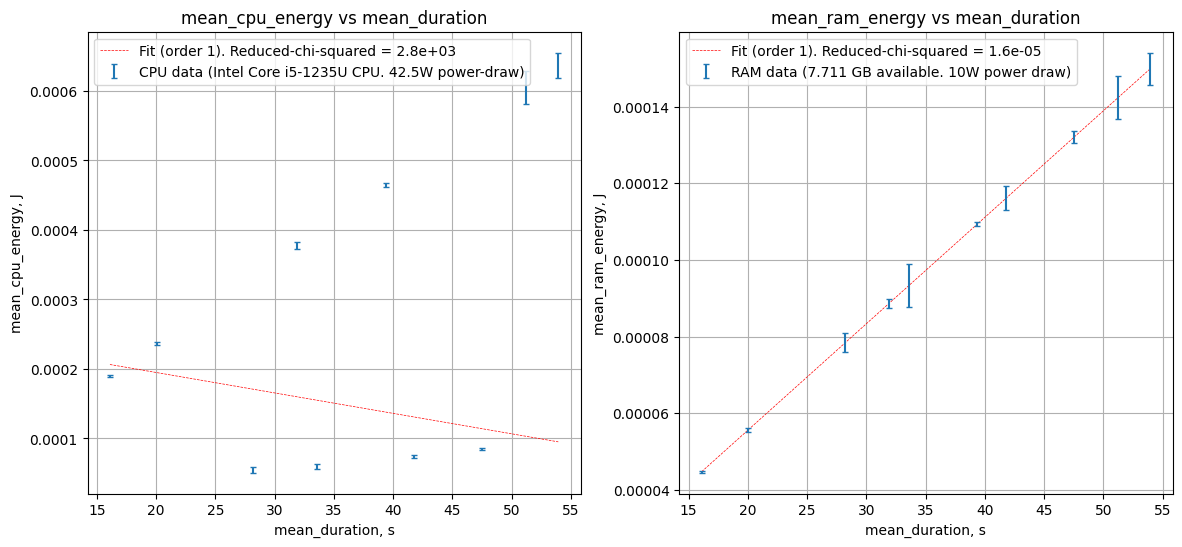

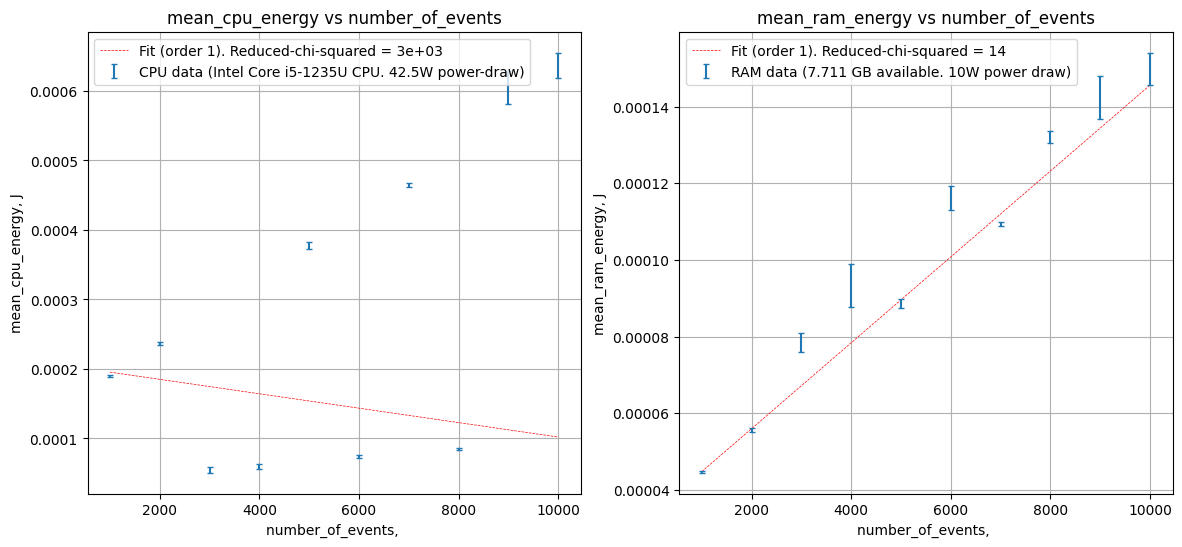

In [25]:
CPU_and_RAM_plotting(gen_summary_df, "mean_duration", 
         "mean_cpu_energy", "cpu_energy_err", 
         "mean_ram_energy", "ram_energy_err", 
         True, 1)
CPU_and_RAM_plotting(gen_summary_df, "number_of_events", 
         "mean_cpu_energy", "cpu_energy_err", 
         "mean_ram_energy", "ram_energy_err", 
         True, 1)